In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:

import sys
import os
import isaacgym
sys.path.append("../../")
from environments.isaac_simulation.env import ISAACSimulationEnv
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt


from utils.logging import CustomLogger
from utils import logging
from agents import agent_factory
from apis.detectors import OWLViT
from apis.segmentors import SAM

from executor import SimpleExecutor, LineWiseExecutor

from utils.image_utils import visualize_image


/home/kaixin/Desktop/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so
Importing module 'gym_38' (/home/kaixin/Desktop/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/kaixin/Desktop/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json


/home/kaixin/anaconda3/envs/dom-issac/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version 2.3.0+cu121
Device count 1
/home/kaixin/Desktop/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /home/kaixin/.cache/torch_extensions/py38_cu121 as PyTorch extensions root...
Emitting ninja build file /home/kaixin/.cache/torch_extensions/py38_cu121/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...


In [3]:
#本机跑serveice别用这个代理
#os.environ["HTTP_PROXY"] = "http://127.0.0.1:7890"
# os.environ["HTTPS_PROXY"] = "http://127.0.0.1:7890"
# os.environ["OPENAI_API_KEY"] =""

In [4]:
logger = CustomLogger()
logging.set_logger(logger)

In [5]:
import numpy as np
np.random.seed(114514)

In [6]:
isaac_env=ISAACSimulationEnv()

In [7]:
isaac_env.setup("need_cup")

Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: disabled


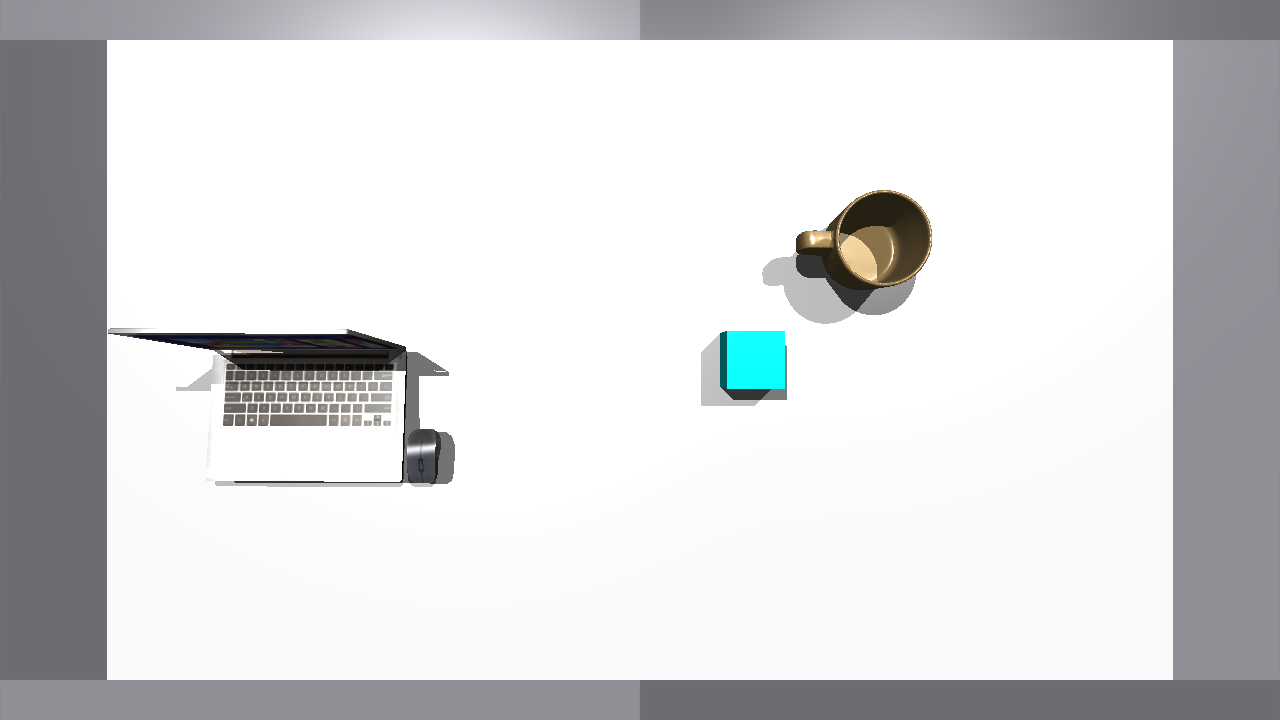

In [8]:
isaac_env.get_image()

In [9]:
image = isaac_env.get_image()

In [10]:
prompt="""I am working on the laptop and I feel thirsty. Put what I need to the bottom of my laptop."""

In [11]:
# name = isaac_env.task._env.pick_place((0.5,-0.1,0.3),(0.6,-0.1,0.3))

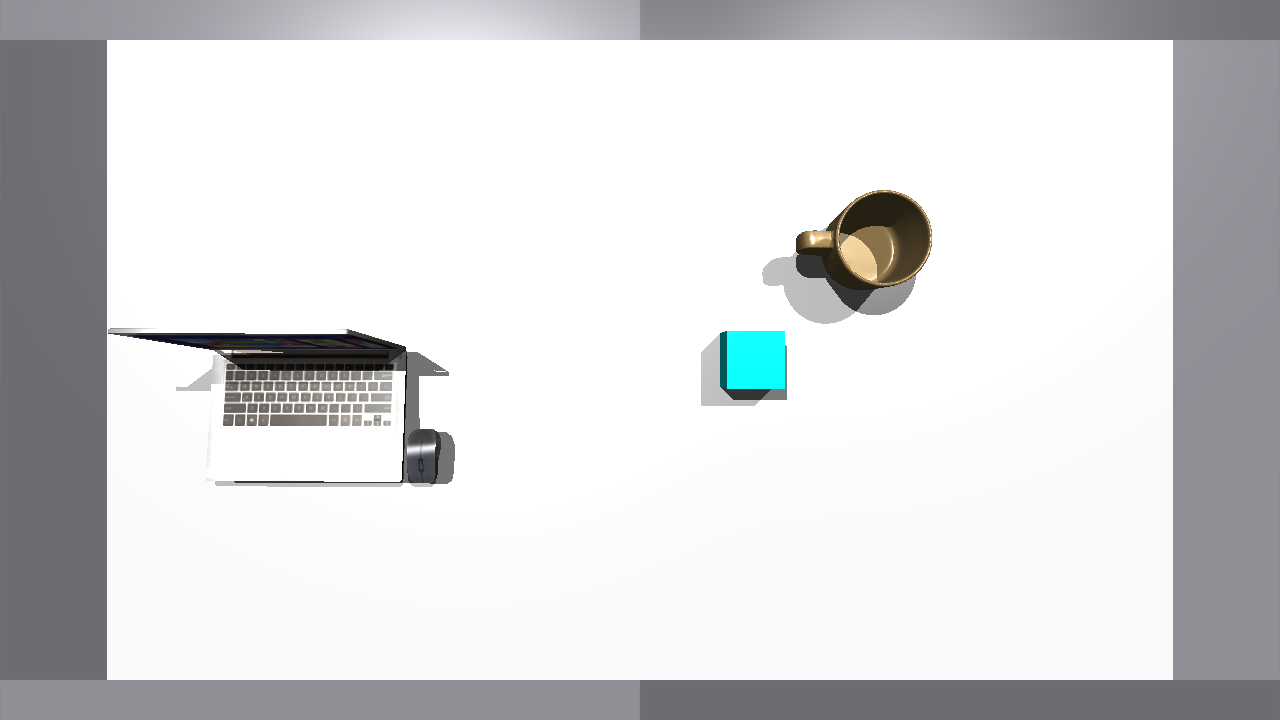

In [12]:
isaac_env.get_image()

In [13]:
model_name = 'DOM'

In [14]:
agent = agent_factory(model_name)

PlanResult(success=True,
 exception=None,
plan_raw="```python\npick(obj=regions[1])\nplace(obj=regions[2], orientation='to_the_bottom_of')\n```",
 masks=<2 masks>,
 prompt='I am working on the laptop and I feel thirsty. Put what I need to the bottom of my laptop.',
 plan_code="\npick(obj=regions[0])\nplace(obj=regions[1], orientation='to_the_bottom_of')\n",
 annotated_image=<PIL.Image.Image image mode=RGB size=1280x720 at 0x7AD0A6089E80>,
 info_dict={'configs': {'label_mode': '1', 'alpha': 0.25}, 'plan_raw_before_inspect': 'To quench your thirst, you\'ll need the cup. I will execute the following actions:\n\n1. pick(cup)\n2. place(laptop, bottom)\n\nHere is the object used in the plan:\n\n```json\n[\n  {"name": "cup"},\n  {"name": "laptop"}\n]\n```'})
Annotated image: 


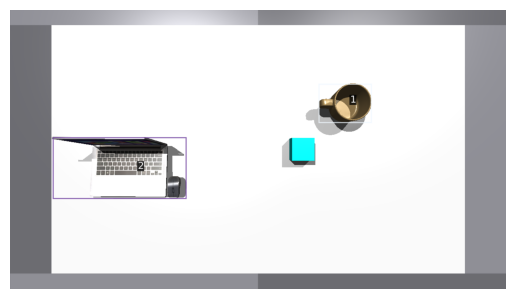

In [15]:
plan_result = agent.try_plan(prompt, image)
print(plan_result)
print("Annotated image: ")
visualize_image(plan_result.annotated_image)

In [16]:
#save the dict
import pickle
if plan_result is not None:
    with open(f"plan_result-need-cup-{model_name}.pkl","wb") as f:
        pickle.dump(plan_result,f)
    import shutil
    shutil.copy(f"plan_result-need-cup-{model_name}.pkl",f"plan_result-need-cup-{model_name}-cp.pkl")

In [17]:
# # 复制一个文件
# import shutil
# shutil.copy(f"plan_result-need-cup-{model_name}.pkl",f"plan_result-need-cup-{model_name}-cp.pkl")

In [18]:
#load the dict
import pickle
with open(f"plan_result-need-cup-{model_name}-cp.pkl","rb") as f:
    plan_result2 = pickle.load(f)

In [19]:
plan_result=plan_result2

In [20]:
plan_result

PlanResult(success=True,
 exception=None,
plan_raw="```python\npick(obj=regions[1])\nplace(obj=regions[2], orientation='to_the_bottom_of')\n```",
 masks=<2 masks>,
 prompt='I am working on the laptop and I feel thirsty. Put what I need to the bottom of my laptop.',
 plan_code="\npick(obj=regions[0])\nplace(obj=regions[1], orientation='to_the_bottom_of')\n",
 annotated_image=<PIL.Image.Image image mode=RGB size=1280x720 at 0x7AD0A60B7EB0>,
 info_dict={'configs': {'label_mode': '1', 'alpha': 0.25}, 'plan_raw_before_inspect': 'To quench your thirst, you\'ll need the cup. I will execute the following actions:\n\n1. pick(cup)\n2. place(laptop, bottom)\n\nHere is the object used in the plan:\n\n```json\n[\n  {"name": "cup"},\n  {"name": "laptop"}\n]\n```'})

In [21]:
isaac_env.task._env.camera_pose.z

1.0

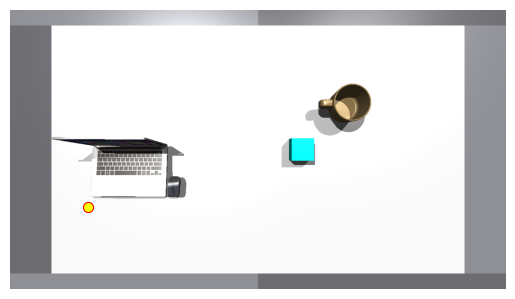

pick_point: 883,238
place_point: 201,506
pick_point_tf: [0.6144465290806754, -0.22795497185741087, 0.415880024433136]
place_point_tf: [0.3630393996247655, 0.41181988742964354, 0.40000003576278687]
pick object distance cup
pick_name cup
pick_handle 2
pick_place success: cup


In [22]:
executor = SimpleExecutor(isaac_env.get_execution_context(agent=agent,init_image=image))
    # Build a context containing the masks for the plan code to access
context = {"regions": [mask["segmentation"] for mask in plan_result.masks]}
executor.execute_plan(plan_result.plan_code, additional_context=context)


In [23]:
isaac_env.task._env.empty_step(10)

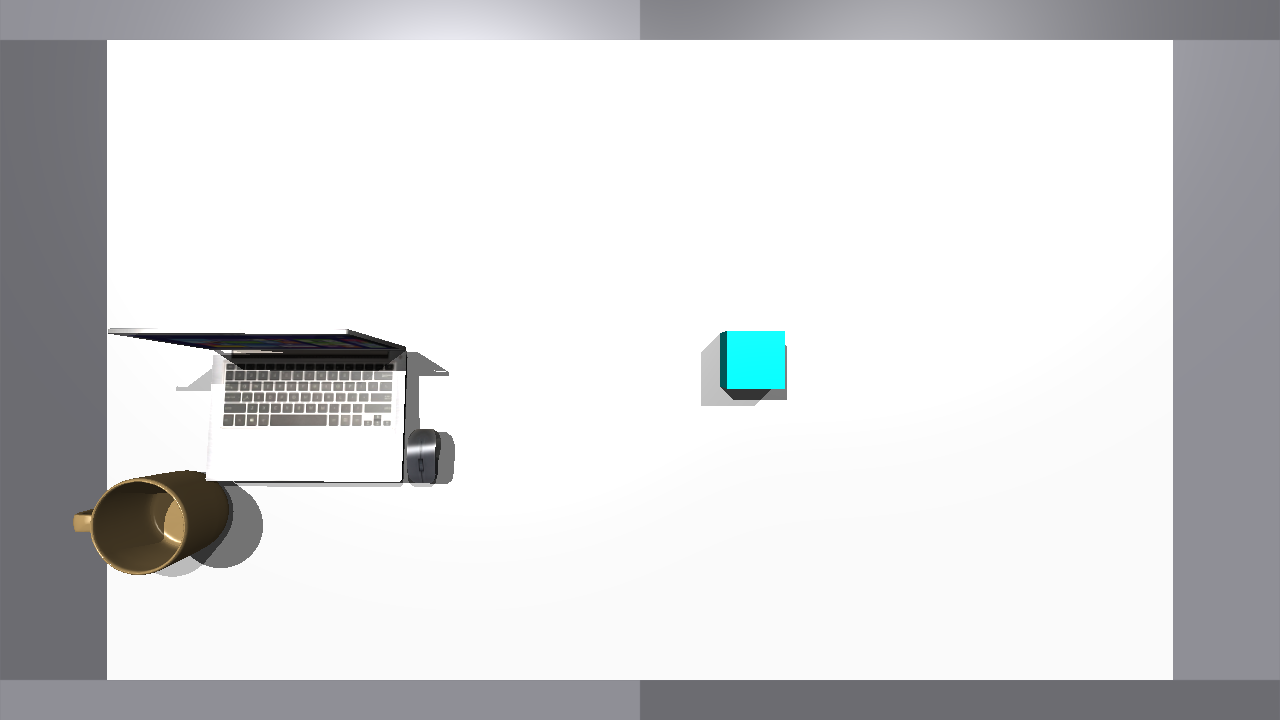

In [24]:
isaac_env.get_image()

In [25]:
image.size

(1280, 720)


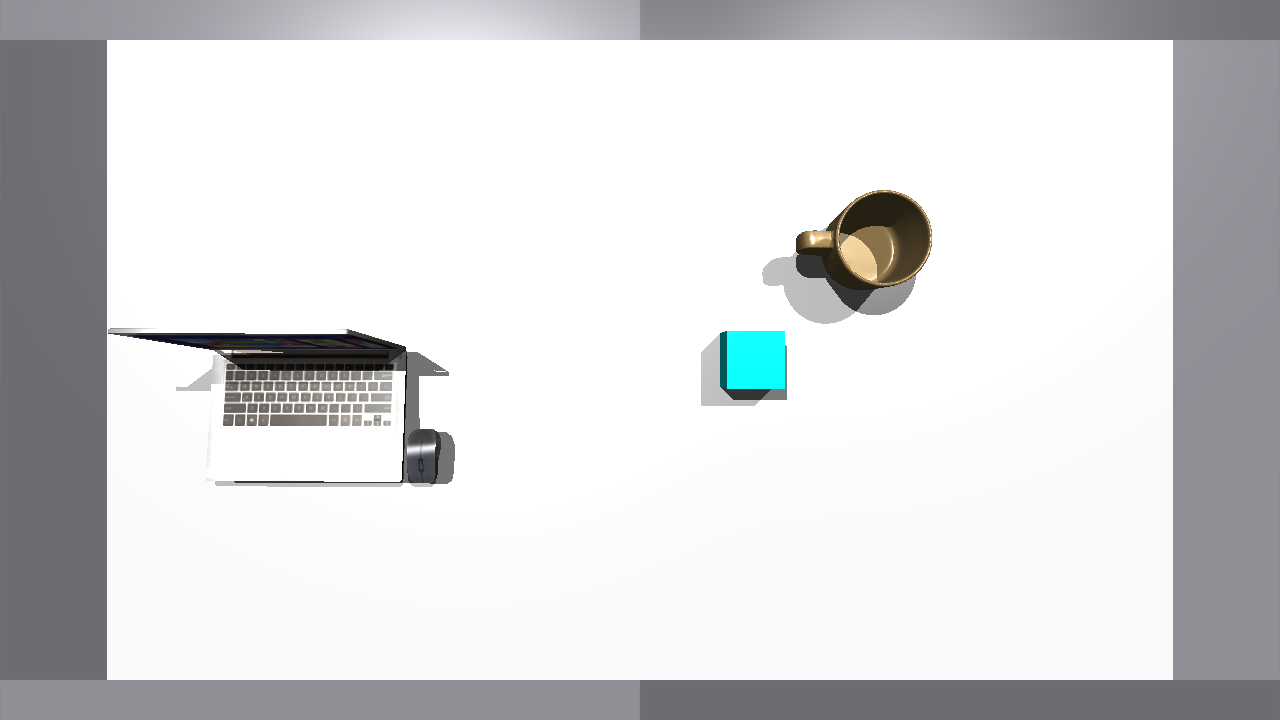
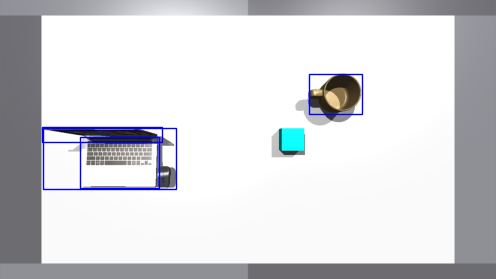
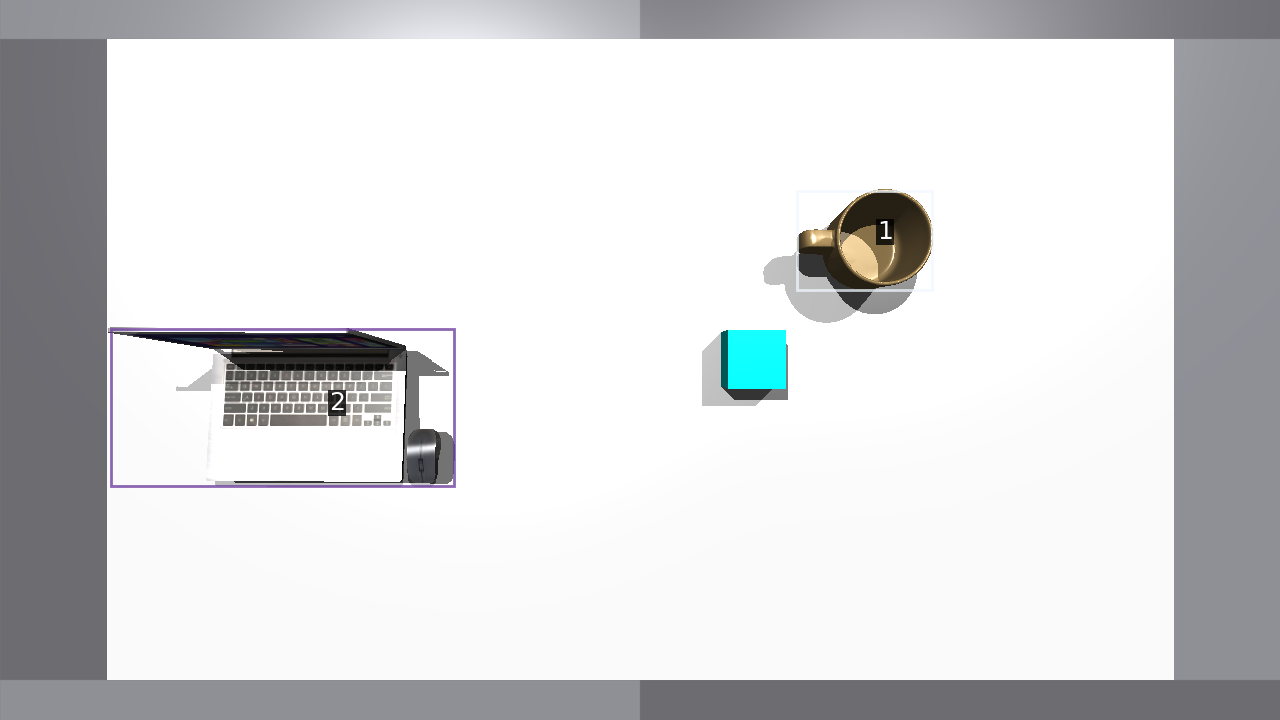
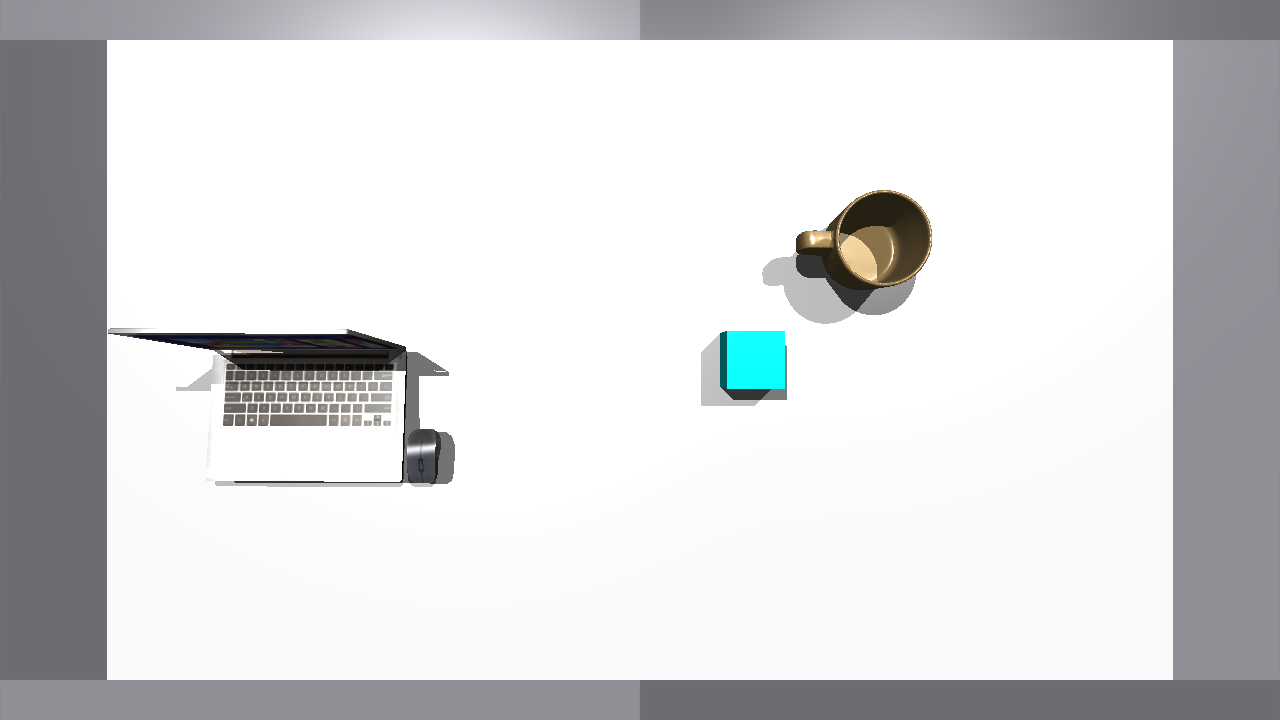
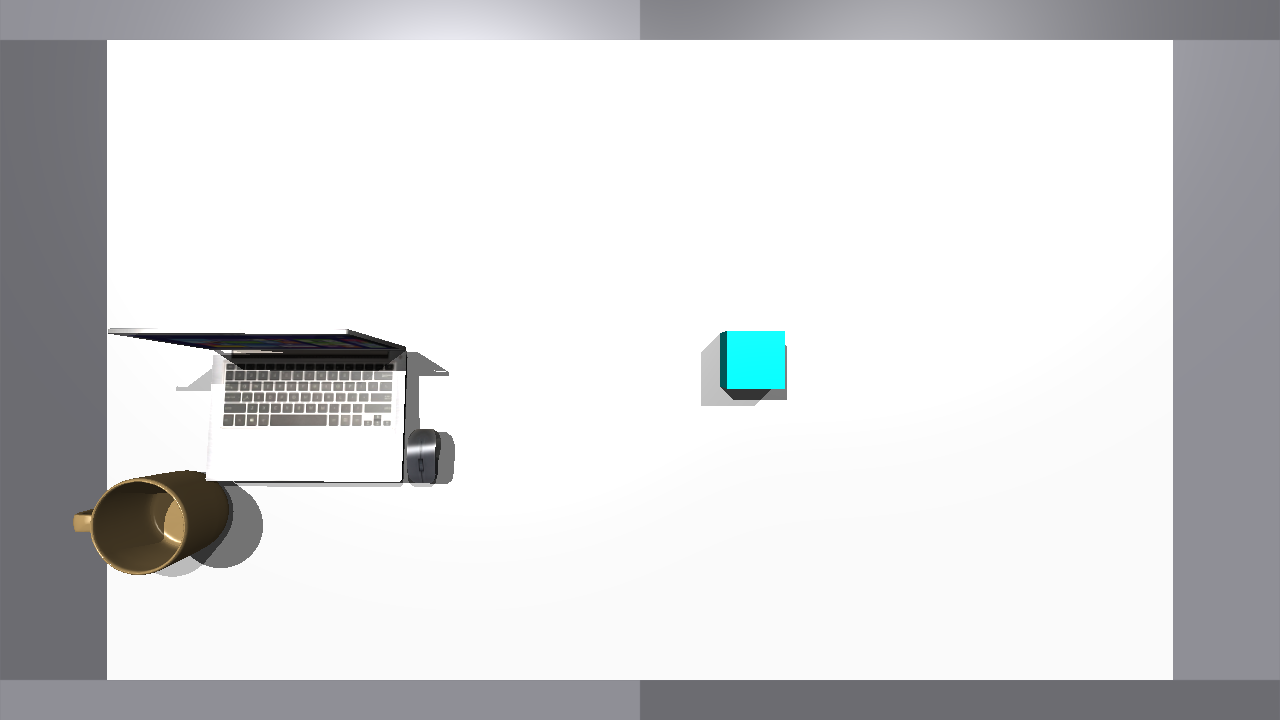

In [26]:
logger.display_html_logs_in_notebook()